In [16]:
%load_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd
import scipy 

from MicroTools import unfolder
from MicroTools.TemplateTools import mcmc_signal
from MicroTools.TemplateTools import miniboone_fit as mbfit
from MicroTools.InclusiveTools import inclusive
import MicroTools.InclusiveTools.inclusive as cern

from MicroTools.TemplateTools import template_analysis as templ

from MicroTools.plot_tools import *

PATH_MCMC_CHAINS = 'MicroTools/mcmc_results'
PATH_PLOTS = 'plots/'

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [17]:
# Test unfolding
my_unfolder = unfolder.MBtomuB(analysis='1eX', remove_high_energy=True, unfold=True, nubar_fraction=0.0)

In [18]:
# Some useful MiniBooNE templates
mb_nominal_template=mbfit.mb_nue_analysis_data -  mbfit.mb_nue_analysis_predicted_background

mb_template_worst = [94.40563491,41.31592711,44.36387293,29.99242961, -6.79081795,19.26734292,-8.77917357, -6.88138706, 7.63200631, -9.47116872, -22.11263405]
mb_template_best=[170.56228436, 84.38734816, 91.74304699, 49.08114012, 19.81931372, 41.51597723, 14.62351973, 12.99344466, 24.8044534, 9.92501774, 7.46580514]

strl = [4.07399, 3.28421, 2.93342, 2.223875, 1.78651, 1.301688, 1.07318, 0.8050, 0.544665, 0.3872957, 0.0817373]
SterileBF = mbfit.bin_width * strl
mb_sterile_best_fit = SterileBF-mbfit.mb_nue_analysis_predicted_background
mb_sterile_best_fit[mb_sterile_best_fit<0]=0

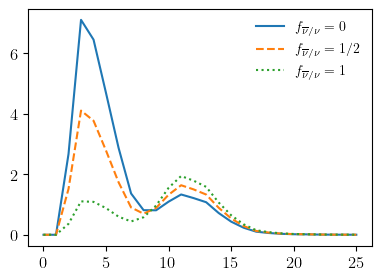

In [19]:
my_unfolder = unfolder.MBtomuB(analysis='1eX0p', remove_high_energy=False, unfold=True, nubar_fraction=0.0)
my_unfolder_half = unfolder.MBtomuB(analysis='1eX0p', remove_high_energy=False, unfold=True, nubar_fraction=0.5)
my_unfolder_all = unfolder.MBtomuB(analysis='1eX0p', remove_high_energy=False, unfold=True, nubar_fraction=1.0)

mub = np.append(0,my_unfolder.miniToMicro(mb_template_worst))
mub_half = np.append(0,my_unfolder_half.miniToMicro(mb_template_worst))
mub_all = np.append(0,my_unfolder_all.miniToMicro(mb_template_worst))

plt.plot(mub, label=r'$f_{\overline{\nu}/\nu}=0$')
plt.plot(mub_half, ls='--', label=r'$f_{\overline{\nu}/\nu}=1/2$')
plt.plot(mub_all, ls=':', label=r'$f_{\overline{\nu}/\nu}=1$')

plt.legend(loc='upper right')

In [20]:
mub_nominal_template= my_unfolder.miniToMicro(mbfit.mb_nue_analysis_data -  mbfit.mb_nue_analysis_predicted_background)
mub_template_worst= my_unfolder.miniToMicro(mb_template_worst)
mub_template_best= my_unfolder.miniToMicro(mb_template_best)

In [21]:
from MicroTools import plot_tools
from matplotlib import cm
from matplotlib.ticker import MultipleLocator
# settings for Fig. 1
TOTAL_RATE = False
INCLUDE_MB_LAST_BIN = True
STACKED = True
PLOT_FAMILY=False
STERILE=False
colormap=cm.Blues
TEMP1_COLOR = 'deeppink'
TEMP2_COLOR = 'dodgerblue'

In [22]:
def make_Fig_1(mb_templates, unfolders, suffix='', legends=['nominal', 'template 1', 'template 2']):
    fig, ax = double_axes_fig(height=0.33, gap=0.17, figsize=(3.2*1.2,3.4*1.2))
    ax1, ax2 = ax
    
    mb_nominal, mb_1, mb_2 = mb_templates
    unfolder_nominal, unfolder_1, unfolder_2 = unfolders
    
    ######################################
    # MiniBooNE 
    if TOTAL_RATE:
        units= 1
        ax1.set_ylabel(r"Events")#/MeV")
    else:
        units = 1/mbfit.bin_width
        ax1.set_ylabel(r"Events/MeV")


    # plot data
    plot_tools.data_plot(ax1, 
            X=mbfit.bin_centers/1e3,
            Y=(mbfit.mb_nue_analysis_data)*units, 
            xerr=np.diff(mbfit.bin_edges)/2/1e3, 
            yerr=np.sqrt(mbfit.mb_nue_analysis_data)*units,
            zorder=1)

    ax1.hist(mbfit.bin_centers/1e3,
        weights=mbfit.mb_nue_analysis_predicted_background*units,
        bins=mbfit.bin_edges/1e3, 
        lw = 1, 
        alpha=0.5,
        zorder=-1,
        facecolor="#beaed4",#(0.8,0.33,0.33),
        label = "backgrounds")    

    plot_tools.step_plot(ax1,
                x=mbfit.bin_edges[:-1]/1e3,
                y=mbfit.mb_nue_analysis_predicted_background*units,
                color='black', 
                zorder=-1, 
                lw=1,
                label="")

        

    plot_tools.step_plot(ax1, 
                x=mbfit.bin_edges[:-1]/1e3,
                y=(mb_nominal+ STACKED*mbfit.mb_nue_analysis_predicted_background)*units,
                color='black',
                label=legends[0])


    plot_tools.step_plot(ax1,
                x=mbfit.bin_edges[:-1]/1e3,
                y=(np.clip(mb_1, 0, np.inf) + STACKED*mbfit.mb_nue_analysis_predicted_background) *units,
                color=TEMP1_COLOR,  
                lw=1,
                label=legends[1])


    plot_tools.step_plot(ax1,
                x=mbfit.bin_edges[:-1]/1e3,
                y=(np.clip(mb_2, 0, np.inf) + STACKED*mbfit.mb_nue_analysis_predicted_background) *units,
                color=TEMP2_COLOR,  
                lw=1,
                label=legends[2])
    if STERILE:
        # plot sterile
        # MiniBooNE event rates
        plot_tools.step_plot(ax1, 
                    x=mbfit.bin_edges[:-1]/1e3,
                    y=(mb_sterile_best_fit+STACKED*mbfit.mb_nue_analysis_predicted_background)*units,
                    color='black',
                    dashes=(1,1),
                    label=r'3+1 best-fit')



    ax1.legend(fontsize=8, markerfirst=False, ncol=2)
    ax1.annotate(text=r'\textbf{MiniBooNE 2018}', xy=(0.0,1.05), xycoords='axes fraction', fontsize=8)
    ax1.set_xlabel(r"Reconstructed $E_\nu^{\rm QE}$ (GeV)", fontsize=9, labelpad=2.5)
    if INCLUDE_MB_LAST_BIN:
        ax1.set_xticks([0.2,0.5,1,1.5,2,2.5,3])
        ax1.set_xlim(0.2,3)
    else:
        ax1.set_xticks([0.2,0.4,0.6,0.8,1,1.2,1.4])
        ax1.set_xlim(0.2,1.5)

    ax1.xaxis.set_major_locator(MultipleLocator(0.5))
    ax1.xaxis.set_minor_locator(MultipleLocator(0.1))


    ######################################
    # MicroBooNE

    plot_tools.step_plot(ax2,
                x=cern.BinEdge[:-1],
                y=np.clip(unfolder_nominal.miniToMicro(mb_nominal), 0, np.inf)+cern.BkgVec*STACKED,
                color='black',  lw=1.,
                label=legends[0])

    plot_tools.step_plot(ax2,
                x=cern.BinEdge[:-1],
                y=np.clip(unfolder_1.miniToMicro(mb_1), 0, np.inf)+cern.BkgVec*STACKED,
                color=TEMP1_COLOR,  lw=1.,
                label=legends[1])

    plot_tools.step_plot(ax2,
                x=cern.BinEdge[:-1],
                y=np.clip(unfolder_2.miniToMicro(mb_2), 0, np.inf)+cern.BkgVec*STACKED,
                color=TEMP2_COLOR,  lw=1.,
                label=legends[2])

    if STERILE:
        plot_tools.step_plot(ax2, 
                    x=cern.BinEdge[:-1],
                    y=np.clip(unfolder_nominal.miniToMicro(mb_sterile_best_fit), 0, np.inf)+cern.BkgVec*STACKED,
                    color='black',
                    dashes=(1,1),
                    label=r'3+1 best-fit')


    # background
    ax2.hist(cern.BinCenter,
        weights=cern.BkgVec,
        bins=cern.BinEdge, 
        lw = 1, 
        facecolor=(0.5,0.88,0.55),
        zorder=-1, 
        label = r"backgrounds")    
    # data plot
    plot_tools.data_plot(ax2, 
            X=cern.BinCenter,
            Y=cern.DatVec, 
            xerr=np.diff(cern.BinEdge)/2, 
            yerr=np.sqrt(cern.DatVec),
            zorder=2)
    plot_tools.step_plot(ax2,
                x=cern.BinEdge[:-1],
                y=cern.BkgVec,
                color='black',  
                lw=0.5,
                zorder=-1,
                label="")

    ax2.xaxis.set_major_locator(MultipleLocator(0.5))
    ax2.xaxis.set_minor_locator(MultipleLocator(0.1))

    ax2.annotate(text=r'\textbf{MicroBooNE 2021} (Inclusive FC unconstrained)', xy=(0.0,1.05), xycoords='axes fraction', fontsize=8)
    ax2.legend(fontsize=7, markerfirst=True, ncol=3, loc='upper right')
    ax2.set_xlabel(r"Reconstructed $E_\nu$ (GeV)", fontsize=9, labelpad=2.5)
    ax2.set_ylabel(r"Events/100 MeV")
    ax2.set_xlim(np.min(cern.BinEdge),np.max(cern.BinEdge))
    # ax.hlines(0,0,2e3, lw=0.75, ls='--', color='black')
    ax2.set_ylim(0,50)

    ax1.annotate(text=r'Arg\"uelles\,et.\,al.\,2021', xy=(0.65,1.05), xycoords='axes fraction', fontsize=8.5)

    fig.savefig(f"{PATH_PLOTS}/Fig_1{suffix}.png", dpi=400)
    fig.savefig(f"{PATH_PLOTS}/Fig_1{suffix}.pdf")

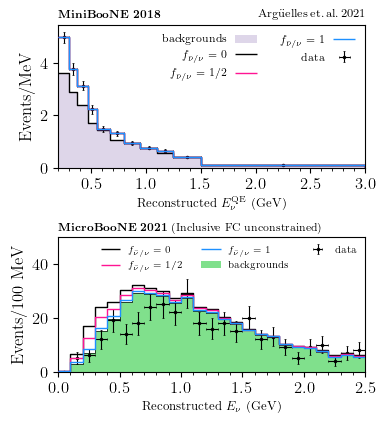

In [23]:
# make_Fig_1(mub_nominal_template, mub_template_worst, mub_template_best)
make_Fig_1( mb_templates=[mb_nominal_template, mb_nominal_template, mb_nominal_template], 
            unfolders=[my_unfolder, my_unfolder_half, my_unfolder_all], 
            legends=[r'$f_{\bar\nu / \nu}=0$',r'$f_{\bar\nu / \nu}=1/2$',r'$f_{\bar\nu / \nu}=1$'],
            suffix='_antinus')

In [24]:
def get_delta_chi2_antinus(f, x=1, template=mb_nominal_template, **kwargs):
    my_unfolder = unfolder.MBtomuB(analysis='1eX0p', remove_high_energy=False, unfold=True, nubar_fraction=f, **kwargs)
    mub_nominal_template = my_unfolder.miniToMicro(x*template)
    chi2_min = inclusive.Chi2_Inclusive(mub_nominal_template*0)
    return inclusive.Chi2_Inclusive(mub_nominal_template) - chi2_min


In [25]:
def get_delta_chi2s_antinus_in_f(fs, **kwargs):
    chi2s=[]
    for f in fs:
        chi2s.append(get_delta_chi2_antinus(f, **kwargs))
    return chi2s

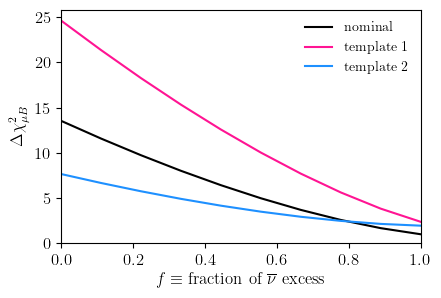

In [26]:
fig, ax = std_fig()

fs = np.linspace(0,1,10, endpoint=True)
ax.plot(fs, get_delta_chi2s_antinus_in_f(fs, **{'template': mb_nominal_template}), color='black', label='nominal')
ax.plot(fs, get_delta_chi2s_antinus_in_f(fs, **{'template': mb_template_best}), color='deeppink', label='template 1')
ax.plot(fs, get_delta_chi2s_antinus_in_f(fs, **{'template': mb_template_worst}), color='dodgerblue', label='template 2')
ax.set_xlabel(r"$f \equiv$ fraction of $\overline{\nu}$ excess")
ax.set_ylabel(r"$\Delta \chi^2_{\mu B}$")
ax.set_xlim(0,1)
ax.set_ylim(0,)
ax.legend(loc="upper right",)
plt.savefig('plots/MicroBooNE_chi2_vs_f.png', dpi=500)

## MicroBooNE templates for x = eLEE strength

In [27]:
def get_microboone_delta_chi2s_in_x(x, f=0.0):
    dchi2s=[]
    for xx in x:
        dchi2s.append(get_delta_chi2_antinus(f, x = xx))
    return dchi2s

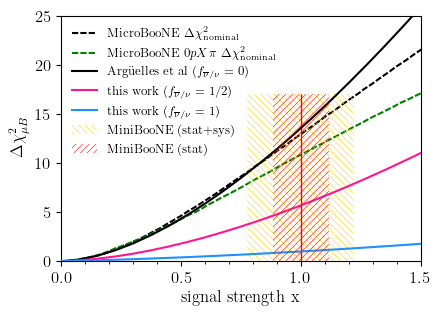

In [28]:
# official_muB_template = np.load("MicroTools/muB_data/inclusive_data/LEE_x1_Expectation.npy")

fig, ax = plot_tools.std_fig(ax_form=[0.12,0.16,0.81,0.8])

df=pd.read_csv("MicroTools/muB_data/inclusive_data/muB_1eX_eLEE_Chi2_Official.csv", sep=',', header=None)
x_official, chi2official = df.values.T[0], df.values.T[1] 
ax.plot(x_official,chi2official, c='black', dashes=(3,1), label=r'\noindent MicroBooNE $\Delta \chi^2_{\rm nominal}$\\\ \,')

x_0p, chi2_0p = np.genfromtxt("MicroTools/muB_data/inclusive_data/Fig32_0p.dat", unpack=True)
ax.plot(x_0p,chi2_0p, c='green', dashes=(3,1), label=r'\noindent MicroBooNE $0pX\pi$ $\Delta \chi^2_{\rm nominal}$\\\ \,')

x = np.linspace(0.001,1.5,21, endpoint=True)
plt.plot(x, get_microboone_delta_chi2s_in_x(x = x, f=0.0), c='black', label=r'Arg\"uelles et al ($f_{\overline{\nu}/\nu} = 0$)', zorder=4)
plt.plot(x, get_microboone_delta_chi2s_in_x(x = x, f=0.5), c='deeppink', label=r'this work ($f_{\overline{\nu}/\nu} = 1/2$)', zorder=4)
plt.plot(x, get_microboone_delta_chi2s_in_x(x = x, f=1.0), c='dodgerblue', label=r'this work ($f_{\overline{\nu}/\nu} = 1$)', zorder=4)


##########
# MINIBOONE 2018

matplotlib.rcParams['hatch.linewidth'] = 0.4
y = [0,17]
NEVENTS=381.2
ERROR = 85.2
ERROR_STATS=np.sqrt(1959)
xleft = (NEVENTS-ERROR)/NEVENTS
xright = (NEVENTS+ERROR)/NEVENTS
ax.fill_betweenx(y,[xleft,xleft],[xright,xright], zorder=3,
                     ec='gold', fc='None',
                     hatch='\\\\\\\\\\',
                     lw=0,
                    label=r'MiniBooNE (stat+sys)')
xleft = (NEVENTS-ERROR_STATS)/NEVENTS
xright = (NEVENTS+ERROR_STATS)/NEVENTS
ax.fill_betweenx(y,[xleft,xleft],[xright,xright], zorder=5,
                     ec='red', fc='None',
                     hatch='/////',
                     lw=0, 
                     label=r'MiniBooNE (stat)')
ax.vlines(1,0,np.max(y), zorder=3, lw=1, color='red')


ax.set_xlim(0,1.5)
ax.set_ylim(0,25)

ax.xaxis.set_major_locator(MultipleLocator(0.5))
ax.xaxis.set_minor_locator(MultipleLocator(0.1))

ax.legend(loc='upper left', fontsize=9)

ax.set_xlabel(r"signal strength x")
ax.set_ylabel(r"$\Delta \chi^2_{\mu B}$")
# ax.annotate(r"Arg\"uelles et. \!al. 2021", xy=(0.63,0.02), xycoords='axes fraction')
# ax.annotate(r"Arg\"uelles et.\,al.\,2021", xy=(0.04,0.42), xycoords='axes fraction')
fig.savefig(f"{PATH_PLOTS}/Fig_2.png", dpi=400)
fig.savefig(f"{PATH_PLOTS}/Fig_2.pdf")

# Ratios of ratios

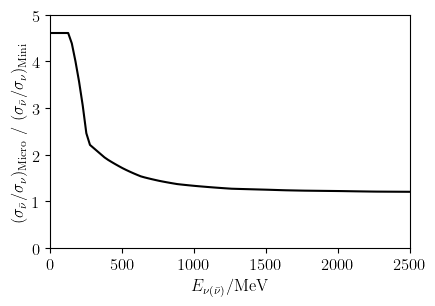

In [29]:
from MicroTools.antinu_tools import get_reweighter_nu_to_antinu_Enu_1D
f = get_reweighter_nu_to_antinu_Enu_1D(experiment='miniboone')
fb = get_reweighter_nu_to_antinu_Enu_1D(experiment='microboone')

fig, ax = std_fig()
Enu = np.linspace(0., 2.5*1e3, 100)
ax.plot(Enu,f(Enu)/fb(Enu), color='black')

ax.set_xlim(0,2.5e3)
ax.set_ylim(0,5)

ax.set_ylabel(r"$(\sigma_{\bar\nu}/\sigma_{\nu})_{\rm Micro}$ / $(\sigma_{\bar\nu}/\sigma_{\nu})_{\rm Mini}$")
ax.set_xlabel(r"$E_{\nu(\bar\nu)}$/MeV")

fig.savefig('plots/ratio_of_ratios_MBvsMicroB.png', dpi=500)